In [1]:
import numpy as np
import BigFunctions as BF
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import uproot as ur
import warnings
warnings.filterwarnings('ignore')

## Parameters to vary
- corr_t: time correlation window
- b: point at origin for Energy 2 as function of Energy 1
- dt_max: maximum $\Delta t$
- N_bins: number of bins used for the fit

## Raw Data

In [2]:
#Reading the variables

input_path = "../data/bigdata_CFD_23092024_0001.root"
with ur.open(input_path) as file:
    outTree = file["DataTree"]
    label = outTree["label"].array(library = "np")
    time = outTree["time"].array(library = "np")*10**-6   #[µs]
    nrj = outTree["nrj"].array(library = "np")
    pileup = outTree["pileup"].array(library = "np")

print("Duration of the data acquisition:  ", max(time)*10**(-6)/3600, "hours")
print("Number of events acquired:         ", len(label)/10**6, "million")
print("Total number of pileups:           ", len(pileup[pileup == True]))
print("Number of events acquired with PM2:", len(label[label == 2])/10**6, "million")

Duration of the data acquisition:   29.660985277428928 hours
Number of events acquired:          38.426892 million
Total number of pileups:            0
Number of events acquired with PM2: 21.276869 million


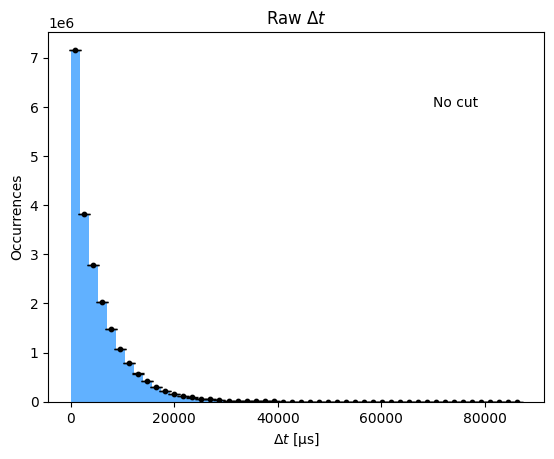

In [3]:
#Raw dt (with PM2)

dt2_raw = time[label == 2][1:] - time[label == 2][:-1]

hist = np.histogram(dt2_raw, bins = 50)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)
plt.figure()
plt.hist(dt2_raw, bins = 50, color='dodgerblue', alpha = 0.7)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k')
plt.scatter(x, y, c='k', s=10)
plt.text(70000, 6e6, 'No cut')
plt.xlabel('$\Delta t$ [µs]')
plt.ylabel('Occurrences')
plt.title('Raw $\Delta t$')
plt.show()

## Correlation

In [4]:
#Time Correlation

corr_t = 10*10**-3   #Correlation window (10 ns here)
corr_mask = (time[1:]-time[:-1]<corr_t) & (label[1:] != label[:-1])

correl_both = (np.insert(corr_mask,0,False))|(np.append(corr_mask,False))
del(corr_mask)

t = time[correl_both]
l = label[correl_both]
p = pileup[correl_both]
e = nrj[correl_both]

t1 = time[correl_both & (label==1)]
t2 = time[correl_both & (label==2)]
nrj1 = nrj[correl_both & (label==1)]
nrj2 = nrj[correl_both & (label==2)]

dt2 = t2[1:]-t2[:-1]
dt1 = t1[1:]-t1[:-1]

print("Number of events after correlation:                       ", len(t)/10**6, "million")
print("Dead time:                                                ", min(dt2), "µs")
print("Total number of pileups after correlation:                ", len(p[p == True]))
print("Number of events acquired with PM2 after time correlation:", len(l[l == 2])/10**6, "million (", len(l[l == 2])*100/len(label[label == 2]), "% )")

Number of events after correlation:                        27.94455 million
Dead time:                                                 0.15847015380859375 µs
Total number of pileups after correlation:                 0
Number of events acquired with PM2 after time correlation: 13.972275 million ( 65.66884911497081 % )


... After time correlation only ...


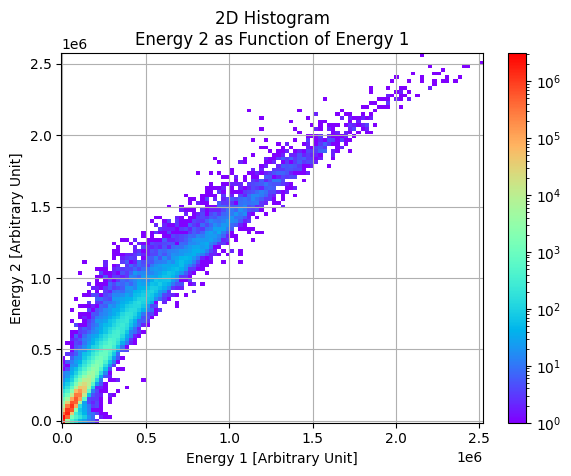

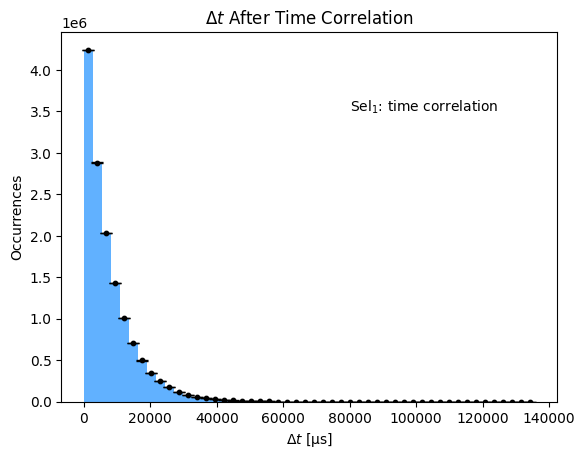

In [5]:
#Energy Correlation

#After time correlation only
print('... After time correlation only ...')

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1, nrj2, bins =(100,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Energy 1 [Arbitrary Unit]')
ax1.set_ylabel('Energy 2 [Arbitrary Unit]')
ax1.set_title('2D Histogram\nEnergy 2 as Function of Energy 1')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

hist = np.histogram(dt2, bins = 50)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)
plt.figure()
plt.hist(dt2, bins = 50, color='dodgerblue', alpha = 0.7)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k')
plt.scatter(x, y, c='k', s=10)
plt.text(80000, 3.5e6, 'Sel$_1$: time correlation')
plt.xlabel('$\Delta t$ [µs]')
plt.ylabel('Occurrences')
plt.title('$\Delta t$ After Time Correlation')
plt.show()

... After correlation and cut on nrj_max ...
a = 2.0000777712010436 +/- 5.863832345345051e-06


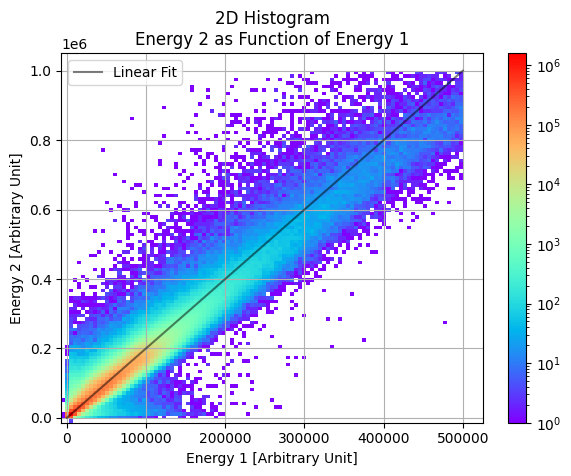

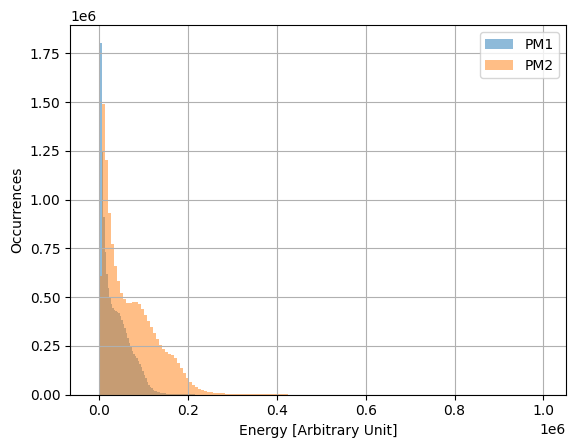

In [6]:
#After correlation and cut on nrj_max
print('... After correlation and cut on nrj_max ...')

nrj1_max = 0.5e6
nrj2_max = 1e6

#First mask: cut on maximum energies
mask1 = (nrj1 < nrj1_max)&(nrj2 < nrj2_max)

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1[mask1], 
                                 nrj2[mask1], 
                                 bins =(100,100))

popt, cov = curve_fit(BF.lin, xe_1, ye_1)
a = popt[0]
a_err = np.sqrt(cov[0,0])
print("a =", a, "+/-", a_err)

pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Energy 1 [Arbitrary Unit]')
ax1.set_ylabel('Energy 2 [Arbitrary Unit]')
ax1.set_title('2D Histogram\nEnergy 2 as Function of Energy 1')
ax1.grid()
ax1.plot(np.array([0, 5e5]), a*np.array([0, 5e5]), c='k', alpha = 0.5, label = 'Linear Fit')
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.legend()
plt.show()

plt.figure()
plt.hist(nrj1[mask1], bins = 150, alpha = 0.5, label = "PM1")
plt.hist(nrj2[mask1], bins = 150, alpha = 0.5, label = "PM2")
plt.xlabel("Energy [Arbitrary Unit]")
plt.ylabel("Occurrences")
plt.grid()
plt.legend()
plt.show()



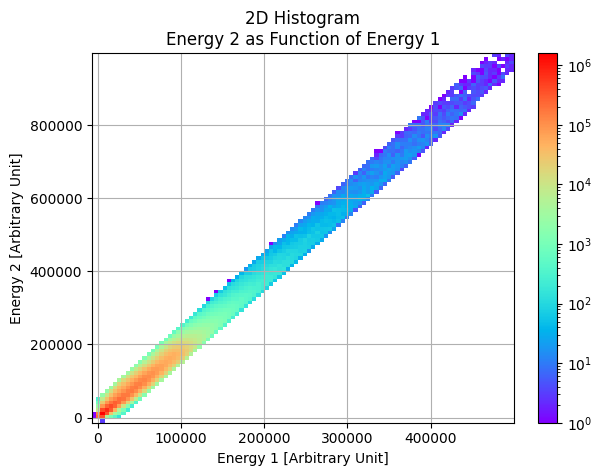

In [7]:
#Linearity

b = 0.05e6

#Second mask: to keep energies around the linear line only
mask2 = (a*nrj1+b>=nrj2) & (a*nrj1-b <= nrj2)

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1[mask1 & mask2], 
                                 nrj2[mask1 & mask2], 
                                 bins =(100,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Energy 1 [Arbitrary Unit]')
ax1.set_ylabel('Energy 2 [Arbitrary Unit]')
ax1.set_title('2D Histogram\nEnergy 2 as Function of Energy 1')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

Number of events acquired with PM2 after time and energy correlation: 13.740023 million ( 64.57727873400921 % )


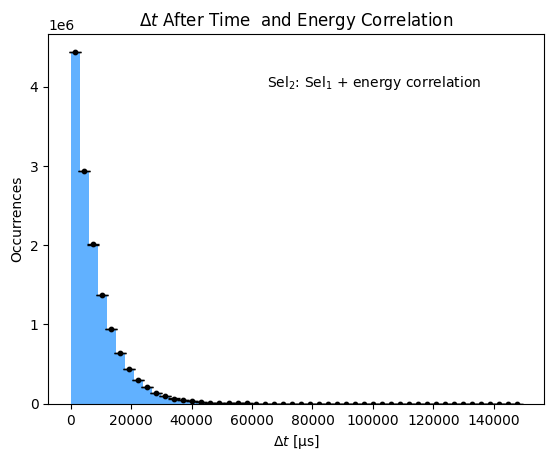

In [8]:
#PM2 variables after correlation cuts (time and energy)
nrj22 = nrj2[mask1 & mask2]
t22 = t2[mask1 & mask2]
dt22 = t22[1:]-t22[:-1]

print("Number of events acquired with PM2 after time and energy correlation:", len(t22)/10**6, "million (", len(t22)*100/len(label[label == 2]), "% )")

hist = np.histogram(dt22, bins = 50)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)
plt.figure()
plt.hist(dt22, bins = 50, color='dodgerblue', alpha = 0.7)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k')
plt.scatter(x, y, c='k', s=10)
plt.text(65000, 4e6, 'Sel$_2$: Sel$_1$ + energy correlation')
plt.xlabel('$\Delta t$ [µs]')
plt.ylabel('Occurrences')
plt.title('$\Delta t$ After Time  and Energy Correlation')
plt.show()

## Additional Cuts

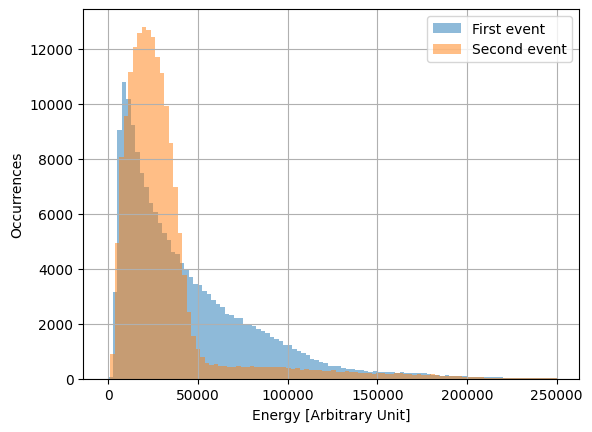

Number of events acquired with PM2 after time and energy correlation, and cut on dt_max:
 0.177587 million ( 0.8346481806134164 % )


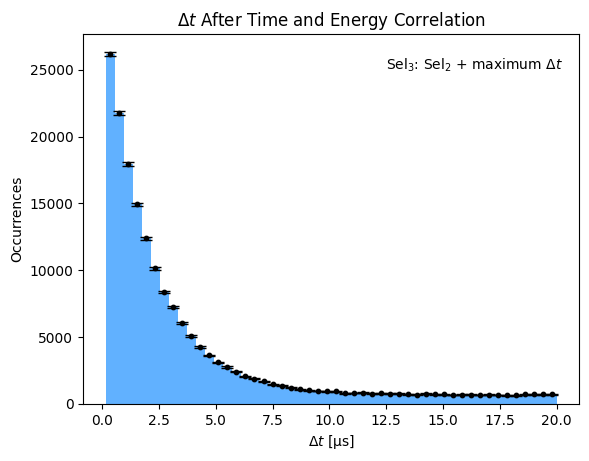

Number of events acquired with PM2 after time and energy correlation, cut on dt_max and on maximum second event energy:
 0.15893 million ( 0.7469614067746528 % )


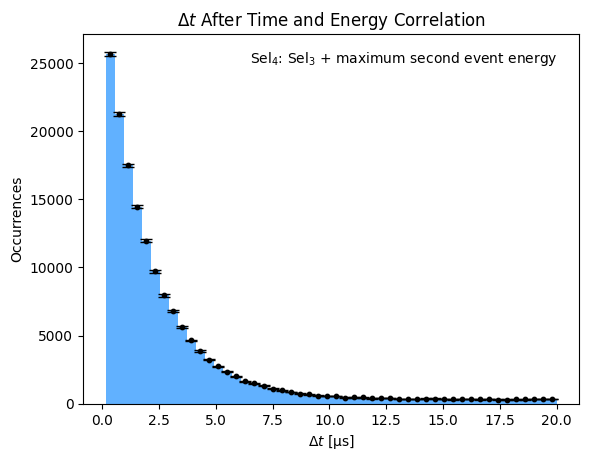

In [14]:
#Cut on maximum dt
dt_max = 20
dt = dt22[(dt22 < 20)&(nrj22[:-1]<0.25e6)&(nrj22[1:]<0.25e6)]
nrjµ = nrj22[:-1][(dt22 < 20)&(nrj22[:-1]<0.25e6)&(nrj22[1:]<0.25e6)]
nrje = nrj22[1:][(dt22 < 20)&(nrj22[:-1]<0.25e6)&(nrj22[1:]<0.25e6)]

plt.figure()
plt.hist(nrjµ, bins = 100, label = 'First event', alpha = 0.5)
plt.hist(nrje, bins = 100, label = 'Second event', alpha = 0.5)
plt.xlabel('Energy [Arbitrary Unit]')
plt.ylabel('Occurrences')
plt.grid()
plt.legend()
plt.show()

print("Number of events acquired with PM2 after time and energy correlation, and cut on dt_max:\n", 
      len(dt)/10**6, "million (", len(dt)*100/len(label[label == 2]), "% )")

hist = np.histogram(dt, bins = 50)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)
plt.figure()
plt.hist(dt, bins = 50, color='dodgerblue', alpha = 0.7)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k')
plt.scatter(x, y, c='k', s=10)
plt.text(12.5, 25000, 'Sel$_3$: Sel$_2$ + maximum $\Delta t$')
plt.xlabel('$\Delta t$ [µs]')
plt.ylabel('Occurrences')
plt.title('$\Delta t$ After Time and Energy Correlation')
plt.show()


#Final cut: energy of the second event (we remove the weird tail)
dt_final = dt22[(dt22 < 20)&(nrj22[:-1]<0.25e6)&(nrj22[1:]<50000)]

print("Number of events acquired with PM2 after time and energy correlation, cut on dt_max and on maximum second event energy:\n", 
      len(dt_final)/10**6, "million (", len(dt_final)*100/len(label[label == 2]), "% )")

hist = np.histogram(dt_final, bins = 50)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)
plt.figure()
plt.hist(dt_final, bins = 50, color='dodgerblue', alpha = 0.7)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k')
plt.scatter(x, y, c='k', s=10)
plt.text(6.5, 25000, 'Sel$_4$: Sel$_3$ + maximum second event energy')
plt.xlabel('$\Delta t$ [µs]')
plt.ylabel('Occurrences')
plt.title('$\Delta t$ After Time and Energy Correlation')
plt.show()

## Fit

... Fit with two exponentials ...
chi2 =  1.0519361301264452 +/- 0.14433756729740643
tau1 =  2.307584607141962 +/- 0.04306796976880913 [µs]
tau2 =  1.7763502570553404 +/- 0.04612848092609021 [µs]


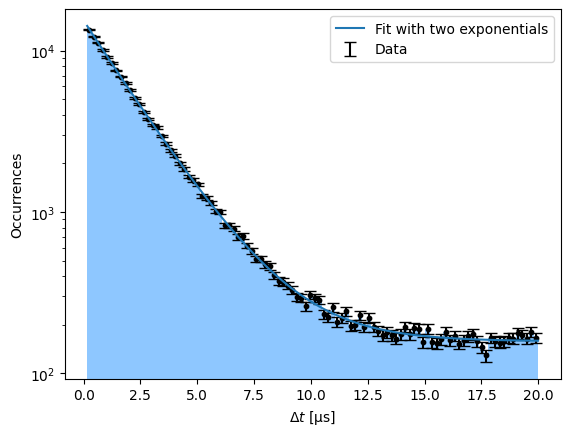

In [12]:
N_bins = 100
hist = np.histogram(dt_final, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

#Fit----------------------------------------------------

popt, cov = curve_fit(BF.exp4, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 2, 400]))
N0 = popt[0]
lam1 = popt[1]
lam1_err = np.sqrt(cov[1,1])
lam2 = popt[2]
lam2_err = np.sqrt(cov[2,2])
C = popt[3]

chi2 = BF.chi2_norm(y, BF.exp4(x, N0, lam1, lam2, C), y_err, 4)[0]
chi2_err = BF.chi2_norm(y, BF.exp4(x, N0,lam1, lam2, C), y_err, 4)[1]
print("... Fit with two exponentials ...")
print("chi2 = ", chi2, '+/-', chi2_err)
tau1 = 1/lam1
tau1_err = lam1_err/lam1**2
tau2 = 1/lam2
tau2_err = lam2_err/lam2**2

print('tau1 = ', tau1, '+/-', tau1_err, '[µs]')
print('tau2 = ', tau2, '+/-', tau2_err, '[µs]')

plt.figure()
plt.hist(dt_final, bins = N_bins, color='dodgerblue', alpha = 0.5)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k', label = 'Data')
plt.scatter(x, y, c='k', s=10)
plt.plot(np.linspace(min(dt_final), max(dt_final), 100), 
         BF.exp4(np.linspace(min(dt_final), max(dt_final), 100), N0, lam1, lam2, C), 
         label = 'Fit with two exponentials')
plt.xlabel("$\Delta t$ [µs]")
plt.ylabel("Occurrences")
plt.yscale('log')
plt.legend()
plt.show()